In [535]:
import pandas as pd
import csv
import numpy as np
from io import StringIO
import requests
from google.cloud import bigquery, storage
from sklearn.metrics.pairwise import haversine_distances
import seaborn as sns
import matplotlib.pyplot as plt

In [536]:
PROJECT_ID = 'lon-trans-streaming-pipeline'

# BigQuery Configuration
BQ_client = bigquery.Client(project=PROJECT_ID)
DATA_SET = 'bus_density_streaming_pipeline'

# Cloud storage configuration
Storage_client = storage.Client(project=PROJECT_ID)
DESTINATION_BUCKET = 'arrivals_data'
DESTINATION_PATH =  f"temporary/arrivals_most_recent_snapshot.csv"
bucket = Storage_client.bucket(DESTINATION_BUCKET)
blob = bucket.blob(DESTINATION_PATH)

In [537]:
# Read Clusters Table

cluster_stations_table = 'stopspoint_coordinates_aggloclusters_enriched'

query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATA_SET}.{cluster_stations_table}`
"""
result =  BQ_client.query(query)


clusterized_stations_df = pd.DataFrame([{'naptanId': row[0],
                                         'commonName': row[1],
                                         'latitude': row[2],
                                         'longitude': row[3],
                                         'clusterAgglomerative': row[4]} 
                                         for row in result])

In [538]:
clusterized_stations_df.head()

,naptanId,commonName,latitude,longitude,clusterAgglomerative
0,490003052N,Abercorn Road,51.60664,-0.20706,0
1,490003108S,Addison Way,51.58793,-0.19977,0
2,490005476N,Alder Grove,51.56650,-0.23377,0
3,49003271DD,Alder Grove,51.56650,-0.23377,0
4,490003218E,Alexandra Road,51.59008,-0.21503,0


In [539]:
# BUS ARRIVALS API CALL
arrivals_url = "https://api.tfl.gov.uk/Mode/bus/Arrivals"
app_key = '132c49c6367b496ba654bc8092f0610a'
url_append = f'?app_key={app_key}' 

arrivals_response = requests.get(arrivals_url + url_append)
arrivals_response_status_code = arrivals_response.status_code

if arrivals_response_status_code == 200:
    arrivals_pred_df = pd.DataFrame(arrivals_response.json())
else:
    print('No Data due to errors')

In [540]:
pd.set_option('display.max_columns', None)
arrivals_pred_df.head()

,$type,id,operationType,vehicleId,naptanId,stationName,lineId,lineName,platformName,direction,bearing,tripId,baseVersion,destinationNaptanId,destinationName,timestamp,timeToStation,currentLocation,towards,expectedArrival,timeToLive,modeName,timing
0,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",-1634863187,2,LJ69YYB,490005800A15,Cromwell Road Bus Station,71,71,A15,inbound,271,223823,20250704,,Chessington,2025-07-17T19:45:07.3821667Z,15,,Hook,2025-07-17T19:45:22Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
1,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",-1435507121,2,LTZ1251,490000138F,Liverpool Street Station,8,8,F,inbound,27,299404,20250704,,Bow Church,2025-07-17T19:45:07.3821667Z,4,,"Bethnal Green, Hackney Or Old Street",2025-07-17T19:45:11Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
2,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",1766530306,2,SK20BCY,490008275K,Holborn Circus,25,25,K,inbound,109,544992,20250704,,"Ilford, Hainault Street",2025-07-17T19:45:07.3821667Z,13,,Bank Or London Bridge,2025-07-17T19:45:20Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
3,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",-1290341376,2,YX17NWE,490007120S,Garner Road / North Arm,w16,W16,WL,outbound,170,400418,20250704,,Leytonstone,2025-07-17T19:45:07.3821667Z,28,,Bakers Arms Or Walthamstow Central,2025-07-17T19:45:35Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...
4,"Tfl.Api.Presentation.Entities.Prediction, Tfl....",-1883592215,2,YX68UTL,490006756W,Farnborough Common / P R U Hospital,261,261,PD,inbound,311,181194,20250704,,Lewisham Station,2025-07-17T19:45:07.3821667Z,1,,Bromley Common,2025-07-17T19:45:08Z,1970-01-01T00:00:00Z,bus,{'$type': 'Tfl.Api.Presentation.Entities.Predi...


In [541]:
# Enrich data with coordinates and clusters

arrivals_pred_df_enriched = arrivals_pred_df[['vehicleId', 'naptanId', 'lineId', 'timestamp', 'timeToStation']].\
    merge(clusterized_stations_df[['naptanId', 'latitude','longitude', 'clusterAgglomerative']], how='left', on='naptanId')
    # dropna(subset='clusterAgglomerative')

arrivals_pred_df_enriched.sort_values(by='vehicleId')

,vehicleId,naptanId,lineId,timestamp,timeToStation,latitude,longitude,clusterAgglomerative
9649,593CLT,490000145LA,2,2025-07-17T19:45:07.3978017Z,370,51.52153,-0.16037,114.0
3053,593CLT,490015317N,2,2025-07-17T19:45:07.3821667Z,70,51.51666,-0.15745,114.0
1263,593CLT,490011133M,2,2025-07-17T19:45:07.3821667Z,17,51.51424,-0.15628,114.0
2991,BD13OHJ,490006768W,220,2025-07-17T19:45:07.3821667Z,69,51.46096,-0.20162,71.0
4947,BD13OHJ,490006048W,220,2025-07-17T19:45:07.3821667Z,139,51.46252,-0.20873,71.0
...,...,...,...,...,...,...,...,...
15085,YY67UUM,490014524W,395,2025-07-17T19:45:07.3978017Z,1115,51.54327,-0.34037,142.0
1821,YY67UUM,490005917Z,395,2025-07-17T19:45:07.3821667Z,34,51.55105,-0.37206,17.0
2809,YY67UUS,490012758E,79,2025-07-17T19:45:07.3821667Z,63,51.60804,-0.28864,65.0
1528,YY67UUS,490000041A,79,2025-07-17T19:45:07.3821667Z,25,51.60754,-0.29435,29.0


In [542]:
# fetch data points that were not found since coordinates havent been assigned to a cluster yet 

not_found_naptan_df = arrivals_pred_df_enriched[arrivals_pred_df_enriched['clusterAgglomerative'].isnull()]
not_found_naptan_df = not_found_naptan_df[not_found_naptan_df['naptanId'] != 'null'][['vehicleId', 'naptanId', 'lineId', 'timestamp', 'timeToStation']]

if len(not_found_naptan_df) > 0: # ---> If there are not found naptanIds
    print('There are some new Naptan Ids with no clusters')

    # Remove them from the enrieched data frame -> They will be appended later
    arrivals_pred_df_enriched = arrivals_pred_df_enriched[~arrivals_pred_df_enriched['naptanId'].isin([n for n in not_found_naptan_df['naptanId']])]

    # Read raw coordinates table to estimate cluster based on haversine_distances

    # not_found_naptan_list = list(not_found_naptan_df['naptanId'])
    
    stations_raw_table = 'stopspoint_coordinates'
    not_found_naptan_df_list = [n for n in not_found_naptan_df['naptanId']]

    if len(not_found_naptan_df_list) > 1:
        raw_stations_coorsinates_query = f"""
            SELECT *
            FROM `{PROJECT_ID}.{DATA_SET}.{stations_raw_table}`        
            WHERE naptanId IN {tuple(not_found_naptan_df_list)}
        """
    else:
        raw_stations_coorsinates_query = f"""
            SELECT *
            FROM `{PROJECT_ID}.{DATA_SET}.{stations_raw_table}`        
            WHERE naptanId IN ({not_found_naptan_df_list[0]})
        """

    raw_stations_coorinates_result =  BQ_client.query(raw_stations_coorsinates_query)
    
    raw_stations_coorinates_df = pd.DataFrame([{'naptanId': row[0], 
                                                'commonName': row[1], 
                                                'latitude': row[2], 
                                                'longitude': row[3]} 
                                                 for row in raw_stations_coorinates_result])
    
    if len(raw_stations_coorinates_df) > 0: # --> If Not found NaptanIds are in Coordinates raw table 
        print('Found those NaptanIds as they are already part of raw coordinates')

        # Apply haversine_distances to each not found coordinate

        clustered_coords = np.radians(clusterized_stations_df[['latitude', 'longitude']].values)
        cluster_labels = clusterized_stations_df['clusterAgglomerative'].values

        proximity_clusters = [] 

        for i in range(0,len(raw_stations_coorinates_df)):
        
            latitude = raw_stations_coorinates_df.iloc[i]['latitude']
            longitude = raw_stations_coorinates_df.iloc[i]['longitude']

            # New point (also in radians)

            new_point = np.radians([[latitude,longitude]])

            # Compute distances to all points
            distances = haversine_distances(clustered_coords, new_point) * 6371.0088  # km

            # Find the closest point and append to list of proximity clusters
            closest_index = np.argmin(distances)
            closest_cluster = cluster_labels[closest_index]

            proximity_clusters.append(closest_cluster)

            # print(f"Closest cluster: {closest_cluster}")

        raw_stations_coorinates_df['clusterAgglomerative'] = proximity_clusters

        # Now merge with not found naptan Ids:
        not_found_naptan_df_enriched = not_found_naptan_df.merge(raw_stations_coorinates_df[['naptanId', 'latitude'	, 'longitude', 'clusterAgglomerative']], how='left', on='naptanId')

        # Append the naptans with enriched data to the original data frame
        final_arrivals_pred_df_enriched = pd.concat([arrivals_pred_df_enriched, not_found_naptan_df_enriched], axis=0, ignore_index=True)

        # Finally, Drop null values in the final enriched in the data frame --> If not found after harvesine proximity that means they are not in the raw coordinates table 

        final_arrivals_pred_df_enriched = final_arrivals_pred_df_enriched.dropna(subset='clusterAgglomerative')
        final_arrivals_pred_df_enriched = final_arrivals_pred_df_enriched [['vehicleId', 'naptanId', 'timeToStation', 'latitude', 'longitude', 'clusterAgglomerative']]
    
    else:
        print('The new naptanIds are not in raw Coordinats table so they wont be considered')
        final_arrivals_pred_df_enriched = arrivals_pred_df_enriched.dropna(subset='clusterAgglomerative')


else:
    print('No Null naptanIds found')
    final_arrivals_pred_df_enriched  =  arrivals_pred_df_enriched
    

There are some new Naptan Ids with no clusters
Found those NaptanIds as they are already part of raw coordinates


In [543]:
raw_stations_coorinates_df

,naptanId,commonName,latitude,longitude,clusterAgglomerative
0,490001223V,Peckham Rye Station,51.46932,-0.06799,52
1,490013477Y,Southampton Row / Theobald's Road,51.51953,-0.12191,55
2,490005619YA,Great Eastern Street,51.52653,-0.08327,137
3,490003924F,Berkeley Street,51.50815,-0.14301,50
4,490014693E,Walm Lane,51.54729,-0.22361,45
5,490014693F,Walm Lane,51.54729,-0.22361,45
6,490015119W,Berkeley Square,51.51053,-0.14462,50
7,490011938U,Savoy Street,51.51077,-0.12048,55


In [544]:
print(final_arrivals_pred_df_enriched.shape)
final_arrivals_pred_df_enriched.head()

(16138, 6)


,vehicleId,naptanId,timeToStation,latitude,longitude,clusterAgglomerative
0,LJ69YYB,490005800A15,15,51.41244,-0.29939,105.0
1,LTZ1251,490000138F,4,51.51749,-0.08064,137.0
2,SK20BCY,490008275K,13,51.51753,-0.10651,112.0
3,YX17NWE,490007120S,28,51.59992,-0.00749,147.0
4,YX68UTL,490006756W,1,51.36557,0.05409,9.0


In [545]:
# Check if we have nulls in final enriched df 

final_arrivals_pred_df_enriched[final_arrivals_pred_df_enriched['clusterAgglomerative'].isnull()]

,vehicleId,naptanId,timeToStation,latitude,longitude,clusterAgglomerative


In [546]:
# Send the most recent data to GCS Temporary file --> IWill copy into official file after extraction and enrichment is complete
csv_buffer = StringIO()
final_arrivals_pred_df_enriched.to_csv(csv_buffer, index=False)
writer = csv.writer(csv_buffer)
blob.upload_from_string(csv_buffer.getvalue(), content_type="text/csv")

In [547]:

#  This will be part of the stremlit app

final_arrivals_pred_df_enriched_grouped = final_arrivals_pred_df_enriched[final_arrivals_pred_df_enriched['timeToStation'] <= 10 * 6000] \
                            .groupby('clusterAgglomerative')['vehicleId'] \
                            .nunique() \
                            .reset_index(name='buses_approaching') \
                            .sort_values(by='buses_approaching', ascending=False)\
                            .merge( final_arrivals_pred_df_enriched.groupby('clusterAgglomerative')[['latitude', 'longitude']].mean().reset_index(), how='left', on='clusterAgglomerative') # Get average LON, LAT for each cluster --> Cluster Centroid basically

In [548]:
final_arrivals_pred_df_enriched_grouped.head()

,clusterAgglomerative,buses_approaching,latitude,longitude
0,50.0,95,51.498956,-0.137686
1,55.0,83,51.527883,-0.111782
2,4.0,80,51.459466,-0.123743
3,6.0,71,51.486241,-0.186136
4,15.0,71,51.503727,-0.232669


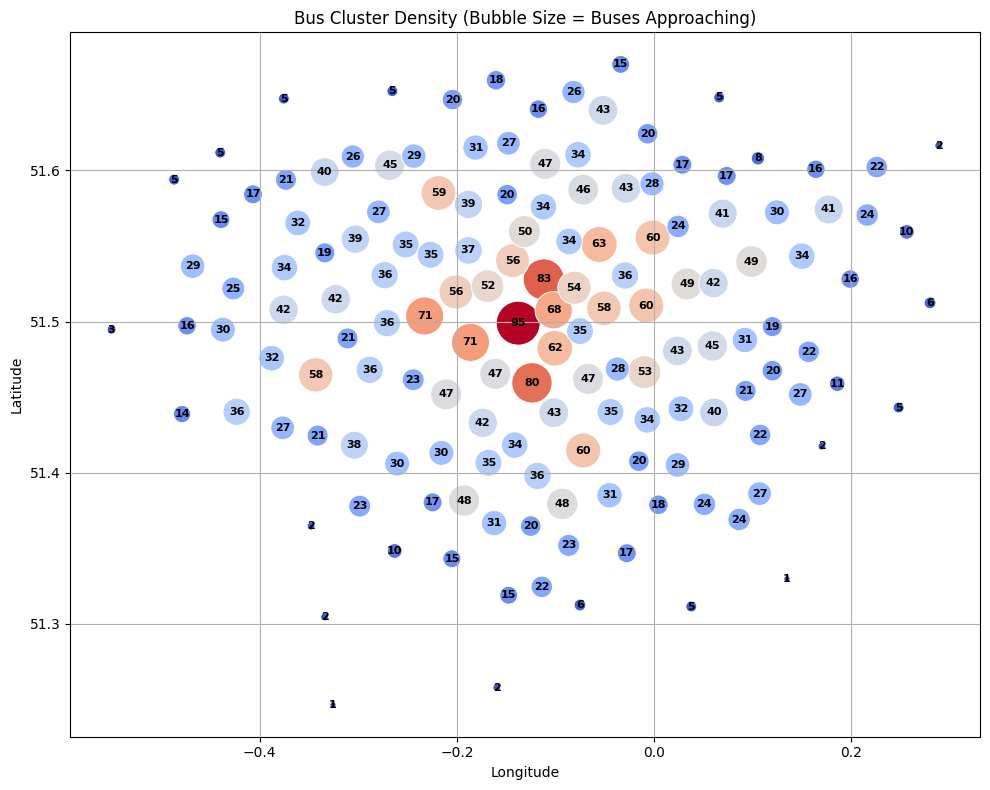

In [549]:

plt.figure(figsize=(10, 8))

# Bubble plot
sns.scatterplot(
    data=final_arrivals_pred_df_enriched_grouped,
    x='longitude',
    y='latitude',
    size='buses_approaching',
    sizes=(20, 1000),
    hue='buses_approaching',
    palette='coolwarm',
    legend=False
)

# Add text labels for each point
for _, row in final_arrivals_pred_df_enriched_grouped.iterrows():
    plt.text(
        row['longitude'],
        row['latitude'],
        str(round(row['buses_approaching'])),
        fontsize=8,
        ha='center',
        va='center',
        color='black',        
        weight='bold'
    )

plt.title("Bus Cluster Density (Bubble Size = Buses Approaching)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()
